# Megabundles On-chain Prediction

This notebook demostrates three models that can be used to predict whether Flashbots megabundles will land on-chain based on the block data that contains bundles  actually landed on-chain. 

Among the three models, one unsupervised learning model is used to find out if there are any features in the block data that might contribute to the outcome of landing on-chain and could be used to predict the same for megabundles; two supervised learning models are used to train the block data in order to predict which megabundles will land on-chain.

The results from these three models are summarised below:

1. **K Means:** Using a two clusters K Means model, `gas_used`, `block_net_profit` and `ssinceblockstart` play important roles in the separation of these two clusters.
2. **Gamma Distribution:** It predicts with a 90% confidence level that 72% of the blocks is expected to have a megabundle land on-chain. The additional profits that could have been made if these megabundles were included on-chain are 7,751 ETH from block number `14000001` to `14132593`.
2. **Logistic Regression:** It predicts with a 90% confidence level that 68% of the blocks is expected to have a megabundle land on-chain. The additional profits that could have been made if these megabundles were included on-chain are 7,069 ETH from block number `14000001` to `14132593`.

## 1. Introduction

The task of this exercise is to use the actual blocks that landed on-chain to predict which megabundles will land on-chain. The aim is to use the on-chain data to train a model and discover important features that can potentially predict if a megabundle can also land on-chain if it also contains these features. 

The predictable event is whether a megabundle will land on-chain or not, which is clearly a binary event. So the model development process will focus on:
- Finding the right method to define this binary event, given the data available for training only contains on-chain data (block data) but not those fail to land on-chain.
- Building a model that can predict the binary event, i.e. the target variable (or dependent variable) is a binary event - 'land on-chain' or 'fail to land on-chain'. The features (or independent variables) are the common fields available in both the training set (block data) and testing set (mev-geth logger megabundle data).

In [301]:
%run ./hide_cell.py

In [302]:

####################
## Load Libraries ##
####################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
from scipy.special import gamma, factorial
from scipy.stats import beta, gamma, pareto, poisson, nbinom
import statsmodels.api as sm
import statsmodels.formula.api as sfa
from scipy import stats
from functools import reduce
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, log_loss, precision_score, f1_score, confusion_matrix, classification_report, mean_squared_error
import woeBinningPandas

####################
## Load Functions ##
####################

def format_date(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

def format_date_ms(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S.%f')

def poisson(k, lamb): 
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def negative_log_likelihood(params, data):
    return -stats.poisson.logpmf(data, params[0]).sum()

def fit_dist(data, data_pred, fit_col, distribution, name, threshold_p):
    ## Convert boundary min value ssinceblockstart = 1 to 0.95 to avoid predicting infinity
    data[fit_col] = np.where(data[fit_col]==1, 0.95, data[fit_col])

    if distribution == 'beta':
        a, b, loc, scale = beta.fit(data[fit_col])
        data[fit_col] = np.where(data[fit_col]==0.95, 1, data[fit_col])
        data[name] = beta.pdf(data[fit_col], a, b, loc, scale)
        data_pred[name] = beta.pdf(data_pred[fit_col], a, b, loc, scale)
        threshold = beta.ppf(threshold_p, a, b, loc, scale)

            
    elif distribution == 'gamma':
        shape, loc, scale = gamma.fit(data[fit_col])
        data[fit_col] = np.where(data[fit_col]==0.95, 1, data[fit_col])
        data[name] = gamma.pdf(x=data[fit_col], a=shape, loc=loc, scale=scale)
        data_pred[name] = gamma.pdf(x=data_pred[fit_col], a=shape, loc=loc, scale=scale)
        threshold = gamma.ppf(threshold_p, shape, loc, scale)
        
    elif distribution == 'pareto':
        shape, loc, scale = pareto.fit(data[fit_col])
        data[fit_col] = np.where(data[fit_col]==0.95, 1, data[fit_col])
        data[name] = pareto.pdf(x=data[fit_col], b=shape, loc=loc, scale=scale)
        data_pred[name] = pareto.pdf(x=data_pred[fit_col], b=shape, loc=loc, scale=scale)
        threshold = pareto.ppf(threshold_p, shape, loc, scale)
        
    elif distribution =='poisson':
        params = minimize(negative_log_likelihood,
                          x0=np.ones(1),
                          args=(data[fit_col],),    
                          method='Powell',          
                          )
        data[fit_col] = np.where(data[fit_col]==0.95, 1, data[fit_col])
        data[name] = stats.poisson.pmf(data[fit_col], params.x)
        data_pred[name] = stats.poisson.pmf(data_pred[fit_col], params.x)
        threshold = stats.poisson.pmf(threshold_p, params.x)
    
    else:
        print("Enter distribution!")
    
    return data, data_pred, threshold


def block_time_unique(data):
    ## Cumulative distribution of time since block start
    agg = pd.DataFrame(data.groupby('ssinceblockstart').size()).reset_index().rename(columns={0:"count"})
    agg['count_perc'] = agg['count']/agg['count'].sum()
    agg['cum_count'] = agg['count'].cumsum()
    agg['cum_count_perc'] = agg['cum_count']/agg['count'].sum()

    return(agg)


def plot_dist(data, plot_type, actual_t, beta_t, gamma_t, pareto_t, tail_lt=None, tail_gt=None, hide_boundary=True):
    
    if (hide_boundary is True):
        data = data[np.invert(data['ssinceblockstart']==1)]
        
    pdf_data = data.rename(columns={"count_perc":"actual"})
    pdf_data_melt = pd.melt(pdf_data, id_vars=['ssinceblockstart'], value_vars=["actual", "fit_beta", "fit_gamma", "fit_pareto"])
    
    if (plot_type=='cdf'):
        ## Cumulative distribution plot
        sns.ecdfplot(data=pdf_data_melt, x="ssinceblockstart", hue="variable").set(title='Cumulative Distribution Plot')
    
    elif (plot_type=='pdf-discrete'):
        ## Density plot - discrete
        sns.histplot(data=pdf_data_melt, x="ssinceblockstart", hue="variable", element="poly").set(title='Probability Density Plot - Discrete')

    elif (plot_type=='pdf-continuous'):
        ## Density plot - continuous
        actual = pdf_data.groupby(['ssinceblockstart','actual']).size().reset_index().rename(columns={0:"actual_count"})
        beta = pdf_data.groupby(['ssinceblockstart','fit_beta']).size().reset_index().rename(columns={0:"beta_count"})
        gamma = pdf_data.groupby(['ssinceblockstart','fit_gamma']).size().reset_index().rename(columns={0:"gamma_count"})
        pareto = pdf_data.groupby(['ssinceblockstart','fit_pareto']).size().reset_index().rename(columns={0:"pareto_count"})

        ## Merge all pdf data into one
        plot_data = [actual, beta, gamma, pareto]
        plot_data = reduce(lambda  left,right: pd.merge(left,right,on=['ssinceblockstart'], how='outer'), plot_data)
        
        if (tail_lt is not None):
            plot_data = plot_data[plot_data['ssinceblockstart']<=tail_lt]
        if (tail_gt is not None):
            plot_data = plot_data[plot_data['ssinceblockstart']>=tail_gt]
        
        print("The actual 90% threshold is: ", round(actual_t,2))
        print("The 90% threshold from beta distribution is: ", round(beta_t,2))
        print("The 90% threshold from gamma distribution is: ", round(gamma_t,2))
        print("The 90% threshold from pareto distribution is: ", round(pareto_t,2))

        plt.plot(plot_data["ssinceblockstart"], plot_data['actual'], label='actual')            
        plt.plot(plot_data["ssinceblockstart"], plot_data['fit_beta'],label='beta')            
        plt.plot(plot_data["ssinceblockstart"], plot_data['fit_gamma'], label='gamma')            
        plt.plot(plot_data["ssinceblockstart"], plot_data['fit_pareto'], label='pareto')            
        plt.axvline(x=actual_t, label='actual threshold', linestyle='dashed', color='blue')
        plt.axvline(x=beta_t, label='beta threshold', linestyle='dashed', color='orange')
        plt.axvline(x=gamma_t, label='gamma threshold', linestyle='dashed', color='lightgreen')
        plt.axvline(x=pareto_t, label='pareto threshold', linestyle='dashed', color='crimson')
        plt.title('Probability Density Plot - 90% CI')
        plt.legend()        
        plt.show()
        
    else:
        print('Input plot type: "cdf", "pdf-discrete", "pdf-continuous"')
            

def unique_mega(data, rule):
    ## Rule 1. select the minimum since block start
    if rule=='min_time':
        mega_data = data.loc[data.groupby('blocknumber').mssinceblockstart.idxmin()]
    
    ## Rule 2. select the max(profit)
    elif rule=='max_profit':       
        mega_data = data.loc[data.groupby('blocknumber').profiteth.idxmax()]

    else:
        print('Input selection rules: "min_time" or "max_profit"!')
        
    ## Aggregated Block Time and 
    agg_mega = block_time_unique(mega_data)
    
    ## Merge with Megabundle data
    mega_data = mega_data.merge(agg_mega, on = 'ssinceblockstart', how='left')
        
    return mega_data, agg_mega

def get_confusion_matrix(cm, classes=None, title = 'Confusion Matrix'):
    if classes is not None:
        ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=100., annot=True, cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+0.5, top-0.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
    
    else:
        ax = sns.heatmap(cm, vmin=0., vmax=100., cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+1.5, top-1.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

def plot_confusion_matrix(y, y_hat, class_name, title):
    cm_train = confusion_matrix(y, y_hat)
    cm_norm_train = cm_train/cm_train.sum(axis=1)[:, np.newaxis]
    plt.figure()
    get_confusion_matrix(cm_norm_train*100, classes=class_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])

def model_performance(y, y_hat):
    print('Balanced Accuracy Score: ', np.round(balanced_accuracy_score(y, y_hat),2))
    print('Log Loss: ', np.round(log_loss(y, y_hat),2))
    out = precision_recall_fscore_support(y, y_hat, average='weighted')
    print('Precision: ', np.round(out[0],2))
    print('Recall: ', np.round(out[1],2))
    print('F-score: ', np.round(out[2],2))

def scatter_plot(x, y, cluster):
    fig, ax = plt.subplots()
    x_name = pd.DataFrame(x).columns.values[0]
    y_name = pd.DataFrame(y).columns.values[0]
    ax.scatter(x,y, c=cluster, label=np.unique(cluster))
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

def bar_plot(df1, df2, groupby1, groupby2, var1, var2, label1, label2, method):
    
    if (method=='mean'):
        data1 = pd.DataFrame(df1.groupby([groupby1])[var1].mean())
        data2 = pd.DataFrame(df2.groupby([groupby2])[var2].mean())
    elif (method=='median'):
        data1 = pd.DataFrame(df1.groupby([groupby1])[var1].median())
        data2 = pd.DataFrame(df2.groupby([groupby2])[var2].median())
    else:
        print("Input method 'mean' or 'median'!")

    data1 = data1.reset_index()
    data2 = data2.reset_index()
    data1 = data1.sort_values(by=[groupby1], ascending = True)
    data2 = data2.sort_values(by=[groupby2], ascending = True)
    
    labels = [label1,label2]
      
    onchain_means =  [data1[var1][1], data2[var2][1]]

    x = np.arange(len(labels))  


    fig, ax = plt.subplots(figsize=(8,5))
    rects1 = ax.bar(x, onchain_means)
    
    ax.set_ylabel(var1)
    ax.set_xticks(x, labels)
    ax.bar_label(rects1, padding=3)
    fig.tight_layout()
    
    plt.show()

    
    
    
hide_toggle()

## 2. Data Preparation
### 2.1 Data Summary

The following datasets are provided:

* **Block data**: (`block.csv` | *primary key*: `block_number`): It contains the actual blocks that landed onchain from block `14000001` to `14132594`. This data will be used as training set to train models to predict whether megabundles will land on-chain. 

* **Block profit** (`updated_profit_data.csv` | *primary key*: `block_number`): It contains each block's net profit from block `14000000` to `14132594`. (an older version `worktest-measured-block-profit.csv` has a shorter history from block `14000000` to `14121050`).

* **Mev-geth logger data** (`mevgeth_log_task-100k_blocks.csv` | *primary key*: `id`): It contains simulated data for megabundles, normal bundles and mempool. This data will be filtered to only contain megabundles and used as testing set. The trained model parameters will be applied to this data to predict whether megabundles will land on-chain. The data is from block `14000001` to `14121050`.

In [303]:
###############
## Data Prep ##
###############

## Load data
logger = pd.read_csv("mevgeth_log_task-100k_blocks.csv")
block = pd.read_csv("block.csv")
block_profit = pd.read_csv("updated_profit_data.csv")
# block_profit = pd.read_csv("worktest-measured-block-profit.csv")

## Sort data by block number
logger = logger.sort_values(by=['blocknumber'], ascending = True)
block = block.sort_values(by=['block_number'], ascending = True)
block_profit = block_profit.sort_values(by=['block_number'], ascending = True)

## Convert timestamp to date format
logger['datetime'] = logger['blocktimestamp'].apply(format_date)

## Check primary key
if (np.unique(block['block_number'].duplicated())==False):
    print('The primary key for block data is: block_number')
if (np.unique(block_profit['block_number'].duplicated())==False):
    print('The primary key for block profit data is: block_number')
if (np.unique(logger['id'].duplicated())==False):
    print('The primary key for mev-geth logger data is: id')


/var/folders/4m/qwlnzsgd3snb4q5grxfm__z00000gn/T/ipykernel_47906/739514833.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  logger = pd.read_csv("mevgeth_log_task-100k_blocks.csv")


The primary key for block data is: block_number
The primary key for block profit data is: block_number
The primary key for mev-geth logger data is: id


### 2.2 Block Data Pre-processing
The following pre-processing steps are done to prepare the block data for modelling:
* Block profit data is merged with block data into one dataset. 
* Seconds since block start - 'ssinceblockstart' is calculated using the 'timestamp' difference from each block. Since 'timestamp' is only available in seconds with 10-digit length, millisecond difference, which requires 13-digit length for 'timestamp', cannot be created.
* Cumulative percentage based on 'ssinceblockstart' ascending order is calculated. It shows that 90% of the blocks landed on-chain are seen in less than or equal to 30 seconds since the block started. 

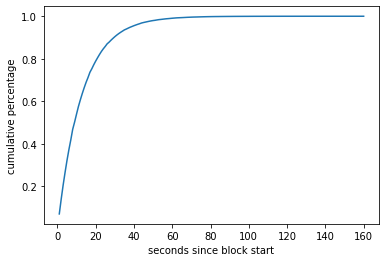

    ssinceblockstart  count  count_perc  cum_count  cum_count_perc
0                1.0   9271    0.069921       9271        0.069921
1                2.0   9254    0.069793      18525        0.139713
2                3.0   8641    0.065169      27166        0.204883
3                4.0   7885    0.059468      35051        0.264350
4                5.0   7429    0.056029      42480        0.320379
5                6.0   6767    0.051036      49247        0.371415
6                7.0   6145    0.046345      55392        0.417760
7                8.0   6662    0.050244      62054        0.468004
8                9.0   4532    0.034180      66586        0.502183
9               10.0   4928    0.037166      71514        0.539350
10              11.0   4788    0.036111      76302        0.575460
11              12.0   4147    0.031276      80449        0.606736
12              13.0   3899    0.029406      84348        0.636142
13              14.0   3628    0.027362      87976        0.66

In [304]:
################
## Block Data ##
################

## Merge block with block profit
block_data = block.merge(block_profit, on = 'block_number', how = 'left')

## Create block length in seconds (can't do millisecond since it needs 13-digit timestamp)
block_data['ssinceblockstart'] = block_data['timestamp'].shift(-1) - block_data['timestamp']
block_data = block_data[np.invert(block_data['ssinceblockstart'].isna())]

## Create gas use percetange
block_data['gas_usage_perc'] = block_data['gas_used']/block_data['gas_limit']

## Aggregated Block Time and merge with Block data
agg_block_time = block_time_unique(block_data)
block_data = block_data.merge(agg_block_time[['ssinceblockstart','count','count_perc']], on = 'ssinceblockstart', how='left')

plt.plot(agg_block_time['ssinceblockstart'], agg_block_time['cum_count_perc'])
plt.xlabel("seconds since block start")
plt.ylabel("cumulative percentage")
plt.show()

print(agg_block_time.head(30))


In a typical model development, the training set (block data) and the testing set (mev-geth logger) need to have common features so the features selected from the model calibration can be used in the model prediction. There are four common variables between the block data and the mev-geth logger data, so these four variables will be used for calibration and prediction:
- ssinceblockstart
- gas used
- gas limit
- block net profit

Three out of the four variables distributions are skewed, as shown in the historgrams and the box-plots below. Log transformation is a method to make the data more comparable and easier to interpret in a chart and also in a model.

<AxesSubplot:xlabel='block_net_profit'>

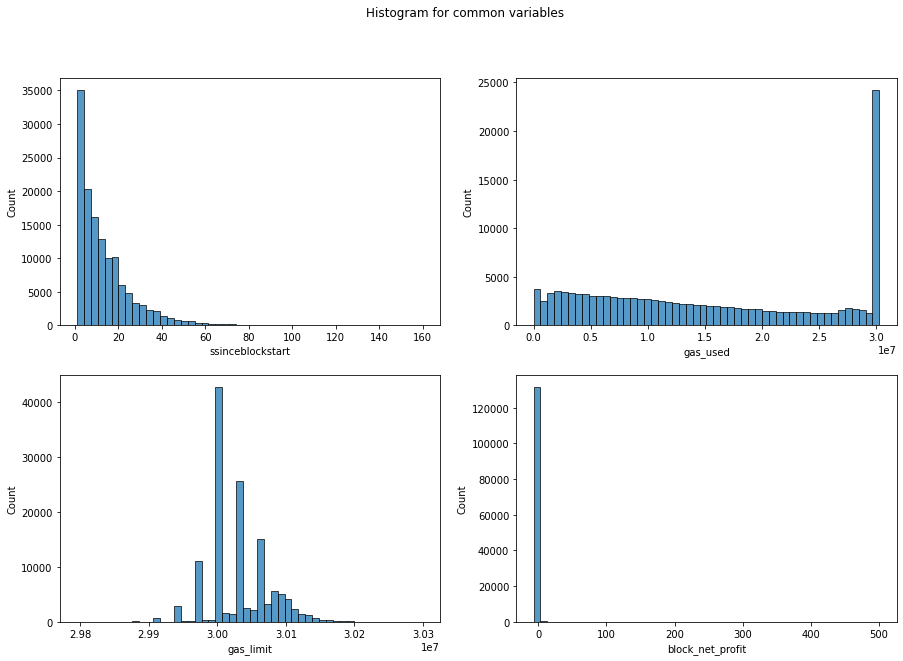

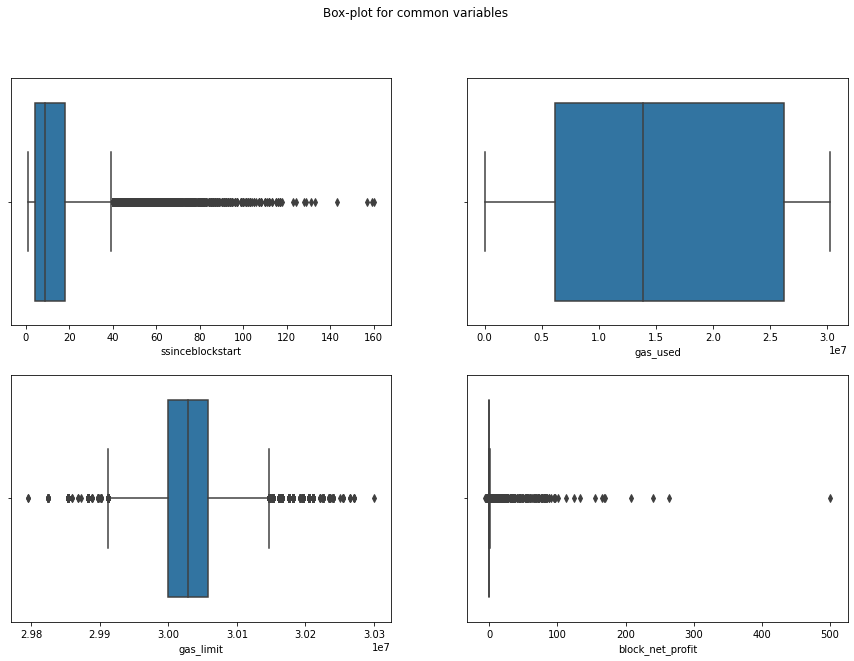

In [305]:
## Histogram for the four common variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('Histogram for common variables')

sns.histplot(ax=axes[0,0], x=block_data["ssinceblockstart"], bins = 50)
sns.histplot(ax=axes[0,1], x=block_data["gas_used"], bins = 50)
sns.histplot(ax=axes[1,0], x=block_data["gas_limit"], bins = 50)
sns.histplot(ax=axes[1,1], x=block_data["block_net_profit"], bins = 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('Box-plot for common variables')

sns.boxplot(ax=axes[0,0], x=block_data['ssinceblockstart'], showfliers = True)
sns.boxplot(ax=axes[0,1], x=block_data['gas_used'], showfliers = True)
sns.boxplot(ax=axes[1,0], x=block_data['gas_limit'], showfliers = True)
sns.boxplot(ax=axes[1,1], x=block_data['block_net_profit'], showfliers = True)


The correlation plot below for the four common variables shows that 'gas_limit' doesn't have much correlation with the other variables. The highest correlation is between 'gas_used' and 'block_net_profit' (62%), followed by 'ssinceblockstart' and 'block_net_profit' (58%), and 'ssinceblockstart' and 'gas_used' (40%).

<AxesSubplot:>

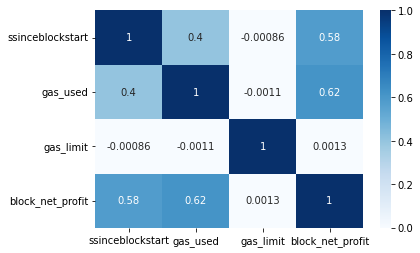

In [306]:
## Preprocess through log transformation
x_log = block_data[['ssinceblockstart','gas_used','gas_limit','block_net_profit']]
x_log = x_log.replace(0, 0.0001)
x_log['block_net_profit'] = np.where(x_log['block_net_profit']<0,0.0001,x_log['block_net_profit'])
x_log = np.log(x_log)

## Correlation plot
sns.heatmap(x_log.corr(), cmap="Blues", annot=True)


### 2.3 Megabundle Data Pre-processing
The testing set megabundle data is preapred and the following pre-processing steps are taken for the model prediction:
* Mev-geth logger data is filtered to only include megabundle.
* Milliseconds are rounded to seconds to match the format from block data, since block data only has seconds but not milliseconds.
* Given there are multiple megabundles per block from the simulated mev-geth logger data, the following two rules are applied in order to only select one megabundle per block:
    - **Rule 1**: Select megabundle with the minimum seconds since block started
    - **Rule 2**: Select megabundle with the maximum profit
* Cumulative distribution based on 'ssinceblockstart' ascending order is calculated based on Rule 1 and Rule 2.

In [307]:
#####################
## Megabundle Data ##
#####################
## Filter only megabundle
mega = logger[logger['workerid']=='megabundle']
mega = mega.sort_values(by=['blocknumber'], ascending = True)

## Convert miliisecond to second
mega['ssinceblockstart'] = np.round(mega['mssinceblockstart']/1000, 0)

## Apply rules to select 1 megabundle per block
# Rule 1: select megabundle with the min time since block start
mega_min_time, agg_mega_min_time = unique_mega(mega, rule="min_time")

## Rule 2: select megabundle with the max profit
mega_max_profit, agg_mega_max_profit = unique_mega(mega, rule="max_profit")


To match the same data structure as the on-chain block data, two rules mentioned above are used to ensure there is only one megabundle per block. Looking at the threshold where the cumulative percentage reaches 90%, similar to the threshold used in the block data, Rule 1 shows the threshold is only 3 seconds, whereas Rule 2 shows 29 seconds, i.e. 90% of the blocks landed on-chain are seen in less than or equal to 29 seconds since the block started. 

It seems the simulated megabundles within a block mostly have at least one very low 'ssinceblockstart'. By applying Rule 1, 90% of the blocks will have less than 3 seconds time since block started, which could be quite different from reality as indicated by the block data and might be too short to use as a threshold.

Rule 2 on the other hand gives a very similar 90 percentile threshold (29 seconds) to the block data threshold (30 seconds). Therefore, Rule 2 is a more reasonable selection rule and will be applied for the testing data.

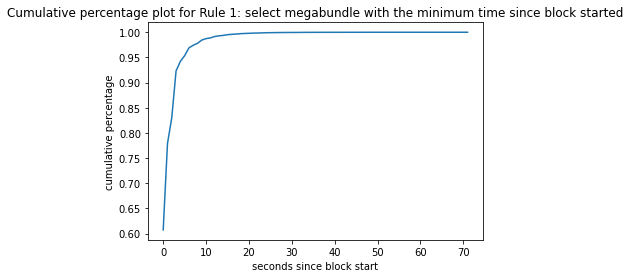

   ssinceblockstart  count  count_perc  cum_count  cum_count_perc
0               0.0  63805    0.607360      63805        0.607360
1               1.0  18034    0.171666      81839        0.779026
2               2.0   5404    0.051441      87243        0.830467
3               3.0   9734    0.092658      96977        0.923125


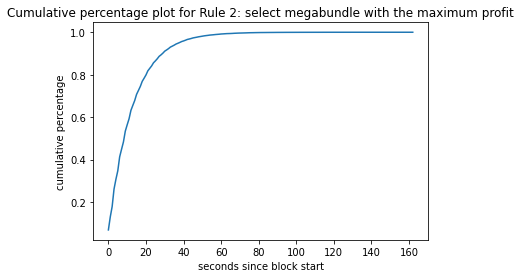

    ssinceblockstart  count  count_perc  cum_count  cum_count_perc
0                0.0   7189    0.068432       7189        0.068432
1                1.0   6425    0.061160      13614        0.129592
2                2.0   5126    0.048794      18740        0.178386
3                3.0   8687    0.082692      27427        0.261078
4                4.0   4810    0.045786      32237        0.306864
5                5.0   4211    0.040085      36448        0.346949
6                6.0   6920    0.065872      43368        0.412820
7                7.0   3729    0.035496      47097        0.448317
8                8.0   3617    0.034430      50714        0.482747
9                9.0   5383    0.051241      56097        0.533988
10              10.0   3125    0.029747      59222        0.563734
11              11.0   2988    0.028443      62210        0.592177
12              12.0   4189    0.039875      66399        0.632052
13              13.0   2433    0.023160      68832        0.65

In [308]:
## Rule 1 cumulative plot
plt.plot(agg_mega_min_time['ssinceblockstart'], agg_mega_min_time['cum_count_perc'])
plt.xlabel("seconds since block start")
plt.ylabel("cumulative percentage")
plt.title('Cumulative percentage plot for Rule 1: select megabundle with the minimum time since block started')
plt.show()

print(agg_mega_min_time.head(4))

## Rule 2 cumulative plot
plt.plot(agg_mega_max_profit['ssinceblockstart'], agg_mega_max_profit['cum_count_perc'])
plt.xlabel("seconds since block start")
plt.ylabel("cumulative percentage")
plt.title('Cumulative percentage plot for Rule 2: select megabundle with the maximum profit')
plt.show()

print(agg_mega_max_profit.head(30))

## 3. Model Development
### 3.1 Unsupervised Learning
Since all the training data (block data) available are those landed on-chain and there is no data for those fail to land on-chain, it is not possible to directly model the target variable as a binary event. To solve this problem, an unsupervised model - **K Means** is used as a first attempt. It is designed to learn patterns from unlabelled data and also to find potential important features that can be used in supervised learning models.

By running a K Means model with two clusters, the model separates the data points based on the distance between each data point in the training set - the points close to each other will be grouped together. In cluster 1 (yellow) there are 129850 data points; while in cluster 2 (purple) there are only 2743 data points.

Although the data is separated into two clusters as pre-defined by the modeler, it is unclear what these two clusters are due to the nature of unsupervised learning. They could just be two random clusters that have nothing to do with bundles landing on-chain or not. The only conclusion can be made from K Means is which features are important in separating these two unknown clusters.

Looking at the scatter plots below, it seems the feature pairs that can clearly distinguish the purple and yellow points without any overlaps are:
- ssinceblockstart vs. gas_used
- block_net_profit vs. gas_used
- gas_limit vs. gas_used

The top two pairs are also observed previously in the correlation plot in section 2.2. 'gas_used' seems to play the most important role in separating the two clusters. The results provide some insight about the feature importance in distinguishing two unknown clusters. 

1    129850
0      2743
Name: km_class, dtype: int64


Text(0, 0.5, 'gas_limit')

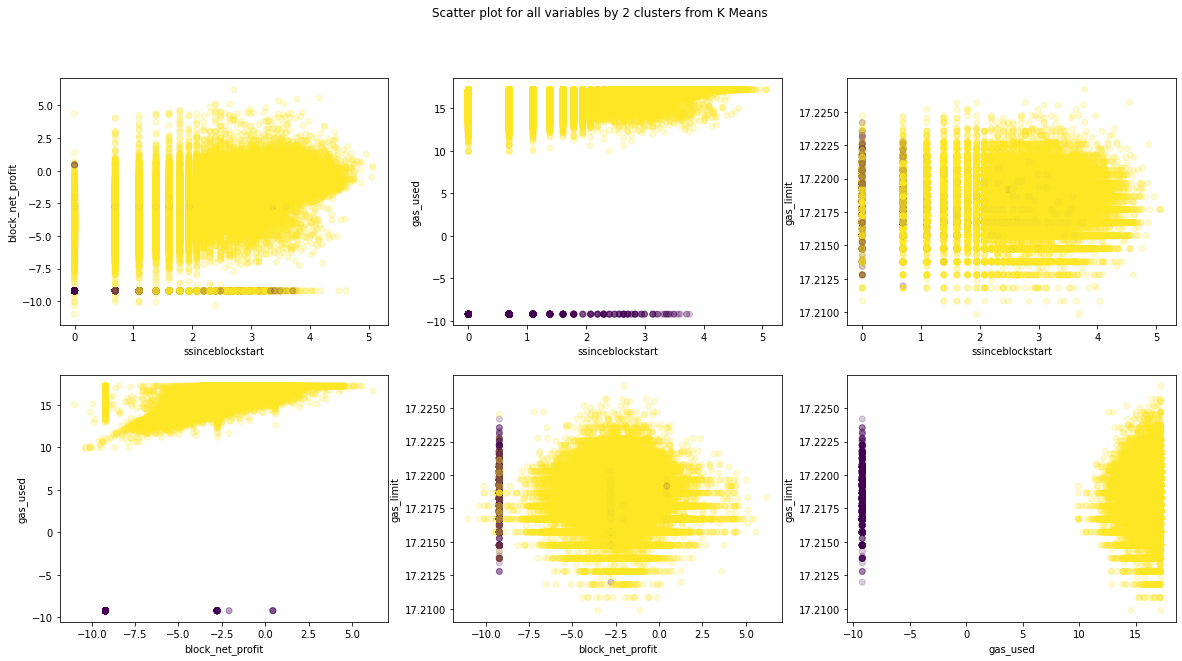

In [309]:
###############################
## 3.1 Unsupervised Learning ##
###############################
###################
## K-Means Model ##
###################

km = KMeans(n_clusters=2,random_state=123).fit(x_log)
block_data['km_class'] = pd.DataFrame(km.predict(x_log))
km_onchain_p = len(block_data[block_data['km_class']==1])/len(block_data)
print(block_data['km_class'].value_counts(dropna=False))

fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
fig.suptitle('Scatter plot for all variables by 2 clusters from K Means')

ax[0,0].scatter(x=x_log['ssinceblockstart'],y=x_log['block_net_profit'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[0,0].set_xlabel('ssinceblockstart')
ax[0,0].set_ylabel('block_net_profit')
    
ax[0,1].scatter(x=x_log['ssinceblockstart'],y=x_log['gas_used'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[0,1].set_xlabel('ssinceblockstart')
ax[0,1].set_ylabel('gas_used')

ax[0,2].scatter(x=x_log['ssinceblockstart'],y=x_log['gas_limit'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[0,2].set_xlabel('ssinceblockstart')
ax[0,2].set_ylabel('gas_limit')

ax[1,0].scatter(x=x_log['block_net_profit'],y=x_log['gas_used'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[1,0].set_xlabel('block_net_profit')
ax[1,0].set_ylabel('gas_used')

ax[1,1].scatter(x=x_log['block_net_profit'],y=x_log['gas_limit'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[1,1].set_xlabel('block_net_profit')
ax[1,1].set_ylabel('gas_limit')

ax[1,2].scatter(x=x_log['gas_used'],y=x_log['gas_limit'], c=block_data['km_class'], label=np.unique(block_data['km_class']), alpha=0.2)
ax[1,2].set_xlabel('gas_used')
ax[1,2].set_ylabel('gas_limit')



### 3.2 Supervised Learning
Although unsupervised learning models can predict clusters (in this case two clusters), it is more commonly used to solve problems with unknown number of clusters. Given the problem to be solved here is whether a megabundle will land on-chain or not, which is clearly a binary event, supervised learning method with labelled target variable is more suitable. 

One challenge mentioned above for the supervise learning model is not having the data for the 0 event - 'fail to land on-chain'. To solve the problem, a threshold is assumed as the cut-off point for the 1 event - 'landing on-chain'. This threshold needs to be strict enough so that any bundle passing this threshold has a very low probability of landing on-chain, thus becomes the 0 event - 'fail to land on-chain'.

From the background information provided, the main barrier for a bundle to land on-chain is how long it has been when it's seen by the miner since the block started.  Given the block time in ETH 1.0 is not fixed and can vary a lot per block, even though it is known the miners normally set the refresh time to 3 seconds to refresh the list of transactions, it is still difficult to pin-point the exact seconds within a block that have the highest probability to be seen and included by miners. 

#### 3.2.1 Single-Factor Model
However, what is reasonable to assume is the shorter time it has been since the block started, the more likely the bundle will be seen by the miner and will land on-chain. Based on this assumption, seconds since block started (`ssinceblockstart`) can be used as a single factor to form a probability density distribution; and the threshold can be chosen from the far right-tail of this distribution to represent the extremely unlikely point that hardly any bundles will land on-chain if they go beyond this point. 

Using this fitted distribution and assuming the megabundles also follow this distribution, any megabundle with ssinceblockstart < threshold will land on-chain and vice versa.

The actual 'ssinceblockstart' distribution is a convex skewed to the right shape, very similar to a fat-tail distribution. Based on this, the following three distributions are used to fit the actual distribution:
- [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution)
- [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- [Pareto Distribution](https://en.wikipedia.org/wiki/Pareto_distribution)



In [310]:
#############################
## 3.2 Supervised Learning ##
#############################
###############################
## 3.2.1.Single Factor Model ##
###############################
## Fit multiple distributions to actual seconds since block start
## Predict megabundle probability of landing on-chain
## Rule 1
block_data, mega_min_time, beta_threshold = fit_dist(block_data, mega_min_time, "ssinceblockstart", "beta", "fit_beta", threshold_p=0.9)           
block_data, mega_min_time, gamma_threshold = fit_dist(block_data, mega_min_time, "ssinceblockstart", "gamma", "fit_gamma", threshold_p=0.9)    
block_data, mega_min_time, pareto_threshold = fit_dist(block_data, mega_min_time, "ssinceblockstart", "pareto", "fit_pareto", threshold_p=0.9) 

## Rule 2
block_data, mega_max_profit, beta_threshold = fit_dist(block_data, mega_max_profit, "ssinceblockstart", "beta", "fit_beta", threshold_p=0.9)           
block_data, mega_max_profit, gamma_threshold = fit_dist(block_data, mega_max_profit, "ssinceblockstart", "gamma", "fit_gamma", threshold_p=0.9)    
block_data, mega_max_profit, pareto_threshold = fit_dist(block_data, mega_max_profit, "ssinceblockstart", "pareto", "fit_pareto", threshold_p=0.9) 


/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/scipy/optimize/_minpack

**Predicted vs. actual distribution - Block Data**

The following probability density plot shows the the actual discrete distributions vs. all the fitted distributions, which are also displayed based on discrete points. The reason they almost look identical is because the fitting is done on these discrete points and they are expected to be very similar.

A better way to compare the fitted distribution with the actual distribution would be to plot the continuous distributions with the fitted parameters, as shown in the next chart.

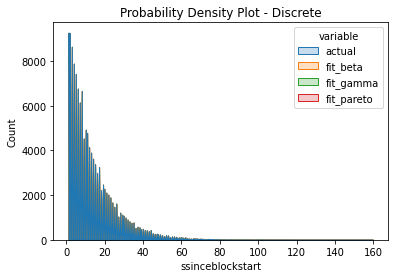

In [311]:
####################################
## Fitted vs. Actual Distribution ##
####################################
actual_threshold = agg_block_time.iloc[(agg_block_time['cum_count_perc']-0.9).abs().argsort()[:1]]['ssinceblockstart'].tolist()[0]
plot_dist(data=block_data, plot_type="pdf-discrete", actual_t=actual_threshold, beta_t=beta_threshold, gamma_t=gamma_threshold, pareto_t=pareto_threshold, tail_lt=None, tail_gt=None, hide_boundary=False)

Looking at the continuous probability density plots below, it is clear that **gamma distribution** has a better fit than the other two in terms of the distribution shape and the threshold. Gamma distribution's 90 percentile is 29.95 seconds, which is very close to the 30 seconds from the actual distribution's 90 percentile. The tails from Beta distribution and Pareto distribution are both too thin compared to the actual distribution, giving larger values compared to the actual distribution.

The actual 90% threshold is:  30.0
The 90% threshold from beta distribution is:  33.74
The 90% threshold from gamma distribution is:  29.95
The 90% threshold from pareto distribution is:  94.65


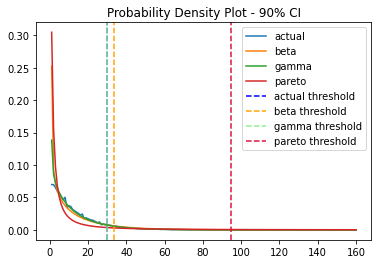

 The optimal distribution is gamma and the threshold is:  29.95


In [312]:
plot_dist(data=block_data, plot_type="pdf-continuous", actual_t=actual_threshold, beta_t=beta_threshold, gamma_t=gamma_threshold, pareto_t=pareto_threshold, tail_lt=None, tail_gt=None, hide_boundary=False)
print(" The optimal distribution is gamma and the threshold is: ", np.round(gamma_threshold, 2))

**Predicted vs. actual distribution - Megabundle Data**

The parameters calibrated from the fitted distributions using the block data are applied to the megabundle data, based on both Rule 1 and Rule 2. The predicted density plots from the three distributions are then compared to the actual.

As mentioned in **Section 2.3**, Rule 1 is not a suitable selection rule to filter megabundle data due to its extremely small 'ssinceblockstart'. This is also shown in the density plot below where the 90 percentile threshold from all the fitted distributions are way above the actual distribution based on Rule 1.

The actual 90% threshold is:  3.0
The 90% threshold from beta distribution is:  33.74
The 90% threshold from gamma distribution is:  29.95
The 90% threshold from pareto distribution is:  94.65


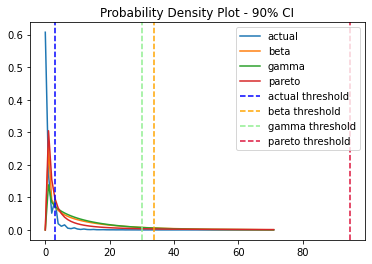

In [313]:
#################################################
## Megabundle (Rule 1) vs. Actual Distribution ##
#################################################
mega_actual_threshold = agg_mega_min_time.iloc[(agg_mega_min_time['cum_count_perc']-0.9).abs().argsort()[:1]]['ssinceblockstart'].tolist()[0]
plot_dist(data=mega_min_time, plot_type="pdf-continuous", actual_t=mega_actual_threshold, beta_t=beta_threshold, gamma_t=gamma_threshold, pareto_t=pareto_threshold, tail_lt=None, tail_gt=None, hide_boundary=False)


Under Rule 2, the actual 'ssinceblockstart' distrbution is very similar to the fitted gamma distribution. And the 90 percentile threshold is almost identical - 29 seconds from the actual distribution vs. 29.95 seconds from the fitted gamma distribution using Rule 2.

This shows that the distribution model built from the training set also fits the testing set well. Gamma distribution is the best fit and Rule 2 - selecting megabundle with the maximum profit, is the more suitable selection.

The actual 90% threshold is:  29.0
The 90% threshold from beta distribution is:  33.74
The 90% threshold from gamma distribution is:  29.95
The 90% threshold from pareto distribution is:  94.65


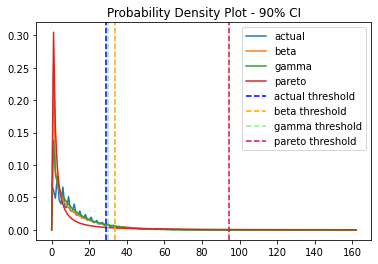

 The optimal distribution is gamma and the threshold is:  29.95


In [314]:
#################################################
## Megabundle (Rule 2) vs. Actual Distribution ##
#################################################
mega_actual_threshold2 = agg_mega_max_profit.iloc[(agg_mega_max_profit['cum_count_perc']-0.9).abs().argsort()[:1]]['ssinceblockstart'].tolist()[0]
plot_dist(data=mega_max_profit, plot_type="pdf-continuous", actual_t=mega_actual_threshold2, beta_t=beta_threshold, gamma_t=gamma_threshold, pareto_t=pareto_threshold, tail_lt=None, tail_gt=None, hide_boundary=False)
print(" The optimal distribution is gamma and the threshold is: ", np.round(gamma_threshold, 2))

**Prediction outcome**

Comparing the Gamma distribution prediction results from the training set - the block data, and the testing set - the megabundle data, the proportion landing on-chain are very similar. 90.4% of the blocks landed on-chain based on the 30 seconds threshold while 91.1% of the megabundles are predicted to land on-chain using the same threshold.

Based on the 30 seconds threshold, the actual and the predicted outcomes are:
Blocks landed on-chain: 119823
Blocks fail to land on-chain: 12770
Predicted # of megabundles land on-chain: 95687
Predicted # of megabundles fail to land on-chain: 9366


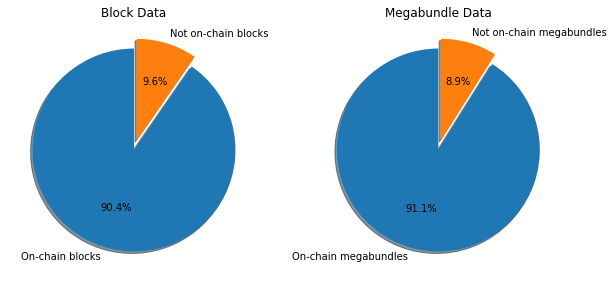

In [315]:
#######################
## Prediction Result ##
#######################
## Set binary on-chain flag based on 30s as threshold
print("Based on the 30 seconds threshold, the actual and the predicted outcomes are:")

block_data['isonchain'] = np.where(block_data['ssinceblockstart']>actual_threshold, 0, 1)
n_block_onchain = block_data[block_data.isonchain == 1].shape[0]
n_block_notonchain = block_data[block_data.isonchain == 0].shape[0]
print("Blocks landed on-chain:", n_block_onchain)
print("Blocks fail to land on-chain:", n_block_notonchain)

mega_max_profit['isonchain'] = np.where(mega_max_profit['ssinceblockstart']>actual_threshold, 0, 1)
n_mega_onchain = mega_max_profit[mega_max_profit.isonchain == 1].shape[0]
n_mega_notonchain = mega_max_profit[mega_max_profit.isonchain == 0].shape[0]
print("Predicted # of megabundles land on-chain:", n_mega_onchain)
print("Predicted # of megabundles fail to land on-chain:", n_mega_notonchain)

## Pie chart
b_labels = 'On-chain blocks', 'Not on-chain blocks'
b_sizes = [n_block_onchain, n_block_notonchain]
m_labels = 'On-chain megabundles', 'Not on-chain megabundles'
m_sizes = [n_mega_onchain, n_mega_notonchain]
explode = (0, 0.1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharey=True)
ax1.pie(b_sizes, explode=explode, labels=b_labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.pie(m_sizes, explode=explode, labels=m_labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.title.set_text('Block Data')
ax2.title.set_text('Megabundle Data')
plt.show()

Comparing the average feature values between the training set and the testing set out of those predicted to land on-chain, megabundles' average gas_used and average block_net_profit are slightly higher than the block's whereas the seconds since block started is slightly lower.

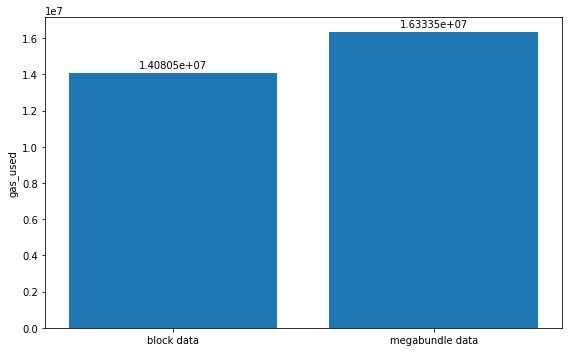

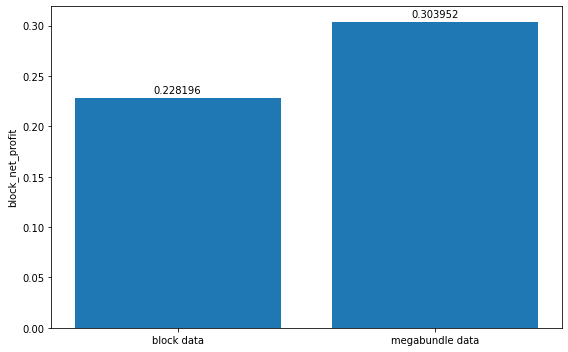

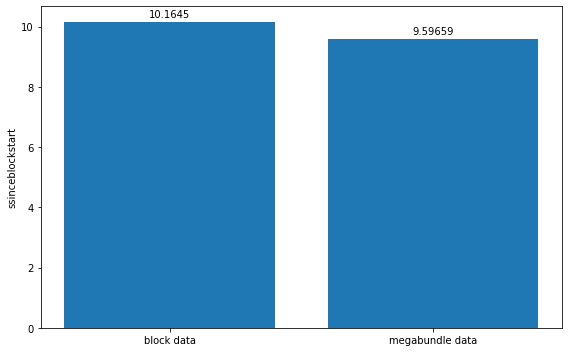

In [316]:
## Average feature value for on-chain blocks and megabundles
bar_plot(block_data, mega_max_profit, groupby1="isonchain", groupby2="isonchain",var1='gas_used', var2='gasused', label1="block data", label2="megabundle data", method='mean')
bar_plot(block_data, mega_max_profit, groupby1="isonchain", groupby2="isonchain",var1='block_net_profit', var2='profiteth', label1="block data", label2="megabundle data", method='mean')
bar_plot(block_data, mega_max_profit, groupby1="isonchain", groupby2="isonchain",var1='ssinceblockstart', var2='ssinceblockstart', label1="block data", label2="megabundle data", method='mean')


When looking at the list of blocks that are predicted to have megabundles, 72% of the total blocks will have a megabundle land on them, 7% have seen a megabundle but fail to include it on-chain. The remaining 21% of the blocks do not have a corresponding simulated megabundle from the mev-geth logger, so the data is not available to tell.

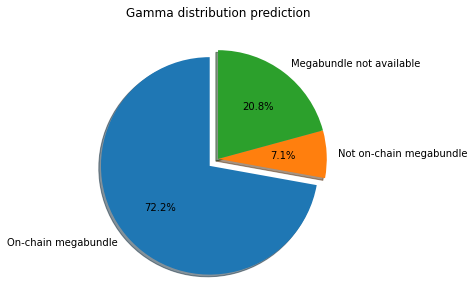

In [317]:
## List of blocks with megabundles predicted to land on-chain
block_mega_profit = block_data.merge(mega_max_profit[['blocknumber','ssinceblockstart','profiteth','isonchain']], left_on='block_number', right_on='blocknumber', how='left')
block_mega_profit = block_mega_profit.rename(columns={"isonchain_x":"isonchain", "isonchain_y":"isonchain_mega",
                                                      "ssinceblockstart_x":"ssinceblockstart", "ssinceblockstart_y":"ssinceblockstart_mega"})

n_notonchain = block_mega_profit[block_mega_profit.isonchain_mega == 0].shape[0]
n_onchain = block_mega_profit[block_mega_profit.isonchain_mega == 1].shape[0]
n_na = block_mega_profit[pd.isna(block_mega_profit.isonchain_mega)].shape[0]

## Percentage of blocks with megabundle land on-chain
labels = 'On-chain megabundle', 'Not on-chain megabundle', 'Megabundle not available'
sizes = [n_onchain, n_notonchain, n_na]
explode = (0.1, 0, 0)
fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title("Gamma distribution prediction")
plt.show()

There are three types of potential profit lost when comparing the actual block profit and the simulated megabundle profit:
- **Total profit lost**: the additional profits that would have been made if megabundles are included, either due to shorter 'ssinceblockstart' or larger profit. Actual block profits that are more than the corresponding megabundle profits are not taken into account here. This is estimated to be **7752 ETH** from the 132,593 blocks.
- **Profit lost due to block latency**: the additional profits that would have been made if megabundles that have shorter 'ssinceblockstart' are included. This is estimated to be **5517 ETH** from the 132,593 blocks.
- **Profit lost due to megabundle latency**: there is a risk that the megabundles predicted to land on-chain might not land on-chain if their 'ssinceblocksstart' is longer than the actual block's recorded 'ssinceblockstart'. So the potential profit lost due to latency in the megabundle is a subset of the total profit lost, with the additional condition that the megabundles' seconds since block started is longer than the block's. This is estimated to be **627 ETH** from the 132,593 blocks.

In [318]:
## Total number of blocks
total_n_blocks = block_mega_profit['block_number'].max()-block_mega_profit['block_number'].min()+1

## Total profit lost (in eth)
block_mega_profit['profit_lost'] = block_mega_profit['profiteth'] - block_mega_profit['block_net_profit']
total_lost = (block_mega_profit[(block_mega_profit['isonchain_mega']==1)&(block_mega_profit['profit_lost']>0)]['profit_lost']).sum()
print('The total profit lost from', total_n_blocks, 'blocks is: ', np.round(total_lost, 0), "ETH")
print('The average profit lost per block is: ', np.round(total_lost/total_n_blocks, 4), "ETH")


## Profit lost due to latency (in eth)
mega_latency_lost = (block_mega_profit[(block_mega_profit['isonchain_mega']==1)&(block_mega_profit['profit_lost']>0)&(block_mega_profit['ssinceblockstart_mega']>block_mega_profit['ssinceblockstart'])]['profit_lost']).sum()
block_latency_lost = (block_mega_profit[(block_mega_profit['isonchain_mega']==1)&(block_mega_profit['profit_lost']>0)&(block_mega_profit['ssinceblockstart_mega']<block_mega_profit['ssinceblockstart'])]['profit_lost']).sum()

print('The profit lost due to block latency is: ', np.round(block_latency_lost, 0), "ETH")
print('The average profit lost per block due to block latency is: ', np.round(block_latency_lost/total_n_blocks, 4), "ETH")

print('The profit that could have been lost due to megabundle latency is: ', np.round(mega_latency_lost, 0), "ETH")
print('The average profit lost per block due to megabundle latency is: ', np.round(mega_latency_lost/total_n_blocks, 4), "ETH")



The total profit lost from 132593 blocks is:  7752.0 ETH
The average profit lost per block is:  0.0585 ETH
The profit lost due to block latency is:  5517.0 ETH
The average profit lost per block due to block latency is:  0.0416 ETH
The profit that could have been lost due to megabundle latency is:  627.0 ETH
The average profit lost per block due to megabundle latency is:  0.0047 ETH


#### 3.2.2 Multi-Factor Model
In the single-factor model, 'ssinceblockstart' is the only factor that determines whether a megabundle will land on-chain or not. Since the 30 seconds threshold is determined now, the target variable can be constructed as a binary variable - 1 (land on-chain) if seconds since block started < threshold; 0 (fail to land on-chain) if seconds since block started > threshold. With a known target variable, a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) with multiple independent variables can be built to predict the binary event.

Given the different scales in the independent variables i.e. `gas_used`, `gas_limit`, `block_net_profit` and `ssinceblockstart`, a weight-of-evidence [WOE](https://documentation.sas.com/doc/en/vdmmlcdc/8.1/casstat/viyastat_binning_details02.htm) transformation is applied. WOE transformation is an effective way to tell the predictive power of an independent variable in relation to the target variable. The regression's coefficients will also be easier to interpret and compare after the WOE transformation.

In [319]:
##############################
## 3.2.2 Multi-Factor Model ##
##############################
## WOE binning ('good' - on-chain, 'bad' - not on-chain)
binning_gaslimit = woeBinningPandas.woe_binning(block_data,"isonchain", "gas_limit", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='not_onchain')
binning_gasused = woeBinningPandas.woe_binning(block_data,"isonchain", "gas_used", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='not_onchain')
binning_profit= woeBinningPandas.woe_binning(block_data,"isonchain", "block_net_profit", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='not_onchain')
binning_time= woeBinningPandas.woe_binning(block_data,"isonchain", "ssinceblockstart", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='not_onchain')
## The higher WOE, the higher % on-chain
block_data['woe_gas_limit'] = pd.cut(block_data['gas_limit'], right=True, bins=binning_gaslimit['cutpoints_final'], labels=binning_gaslimit['woe'][:len(binning_gaslimit)-1])
block_data['woe_gas_used'] = pd.cut(block_data['gas_used'], right=True, bins=binning_gasused['cutpoints_final'], labels=binning_gasused['woe'][:len(binning_gasused)-1])
block_data['woe_block_net_profit'] = pd.cut(block_data['block_net_profit'], right=True, bins=binning_profit['cutpoints_final'], labels=binning_profit['woe'][:len(binning_profit)-1])
block_data['woe_ssinceblockstart'] = np.where(block_data['ssinceblockstart']<=25, binning_time['woe'][0], binning_time['woe'][1])


/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:512: UserWarning: Incorrect specification of data frame and/or variables.
  warnings.warn("Incorrect specification of data frame and/or variables.")
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append met

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBin

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinnin

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBin

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:148: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBin

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinningPandas/__init__.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  freq_table =freq_table.append(missing,ignore_index=True, sort=False)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/woeBinnin

**Initial run**

The initial run of the logistic regression includes all the four WOE transformed variables. The p-value shows that gas_limit is insignificant. This is consistent with previous findings from the correlation plots from K Means unsupervised learning. The pseudo R-squared is 67% from the initial regression.

In [320]:
#################################
## 3.2.2.1 Logistic Regression ##
#################################
## Create training set from Block data
x_train = block_data[['woe_gas_limit','woe_gas_used','woe_block_net_profit','woe_ssinceblockstart']]
y_train = block_data[['isonchain']]

## Create testing set from Megabundle data
##  Transform megabundle data to woe form
mega_data = mega_max_profit
# mega_data = mega_min_time <-- uncomment to use rule 1 
mega_data['woe_gas_limit'] = pd.cut(mega_data['gaslimit'], right=True, bins=binning_gaslimit['cutpoints_final'], labels=binning_gaslimit['woe'][:len(binning_gaslimit)-1])
mega_data['woe_gas_used'] = pd.cut(mega_data['gasused'], right=True, bins=binning_gasused['cutpoints_final'], labels=binning_gasused['woe'][:len(binning_gasused)-1])
mega_data['woe_block_net_profit'] = pd.cut(mega_data['profiteth'], right=True, bins=binning_profit['cutpoints_final'], labels=binning_profit['woe'][:len(binning_profit)-1])
mega_data['woe_ssinceblockstart'] = np.where(mega_data['ssinceblockstart']<=25, binning_time['woe'][0], binning_time['woe'][1])

x_test = mega_data[['woe_gas_limit','woe_gas_used','woe_block_net_profit','woe_ssinceblockstart']]
y_test = mega_data[['isonchain']]

## Initial run
logreg_stat = sm.Logit(y_train, x_train).fit()
logreg_stat.params
logreg_stat.summary()


Optimization terminated successfully.
         Current function value: 0.104612
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isonchain   No. Observations:               132593
Model:                          Logit   Df Residuals:                   132589
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Jun 2022   Pseudo R-squ.:                  0.6699
Time:                        16:16:59   Log-Likelihood:                -13871.
converged:                       True   LL-Null:                       -42018.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
woe_gas_limit            0.0045      0.006      0.747      0.455      -0.007       0.016
woe_gas_used             0.0014      0.000     10.714      0.000       0.001       0.002
woe_block_net_profit     0.0007      0.000      4.421      0.000       0.000       0.001
woe_ssinceblockstart     0.0049   3.68e-05    132.924      0.000       0.005       0.005
========================================================================================
"""

**Final model**

The final model excludes the insignificant variable - gas_limit and has three independent variables in the end. All three variables are significant and the model gives a pseudo R-squared of 67%.

**Prediction outcome**

Using the coefficients calibrated from the Logistic regression, the binary event land on-chain or not can be predicted for the testing set - megabundle data. Comparing the prediction results from the training set and the testing set, the proportion landing on-chain based on the 30 seconds threshold for the block data is 85.8% while 86.5% of the megabundles are predicted to land on-chain using the same threshold.

In [321]:
## Final model - exclude insignificant variable gas_limit
logreg_final = sm.Logit(y_train, x_train.drop(['woe_gas_limit'], axis=1)).fit()
logreg_final.params
logreg_final.summary()


Optimization terminated successfully.
         Current function value: 0.104615
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isonchain   No. Observations:               132593
Model:                          Logit   Df Residuals:                   132590
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Jun 2022   Pseudo R-squ.:                  0.6699
Time:                        16:17:06   Log-Likelihood:                -13871.
converged:                       True   LL-Null:                       -42018.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
woe_gas_used             0.0014      0.000     10.723      0.000       0.001       0.002
woe_block_net_profit     0.0007      0.000      4.421      0.000       0.000       0.001
woe_ssinceblockstart     0.0049   3.68e-05    132.924      0.000       0.005       0.005
========================================================================================
"""

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['axis']
  warnings.warn(msg, ValueWarning)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['axis']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.104615
         Iterations 8
Blocks landed on-chain: 113761
Blocks fail to land on-chain: 18832
Megabundles landed on-chain: 90861
Megabundles fail to land on-chain: 14192


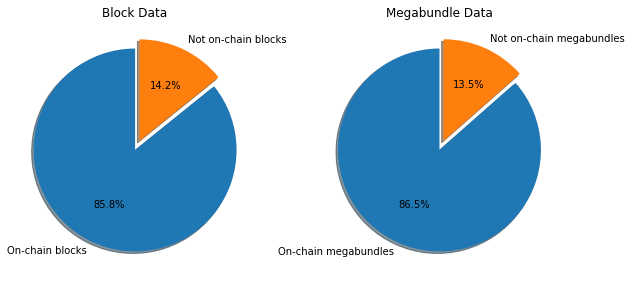

In [322]:
## Training set (block data) prediction
block_data['isonchain_lr'] = logreg_final.predict(x_train.drop(['woe_gas_limit'], axis=1))
block_data['isonchain_lr'] = pd.DataFrame(list(map(round, block_data['isonchain_lr'] )))

lr_block_onchain = block_data['isonchain_lr'][block_data['isonchain_lr']==1].shape[0]
lr_block_notonchain = block_data['isonchain_lr'][block_data['isonchain_lr']==0].shape[0]
print("Blocks landed on-chain:", lr_block_onchain)
print("Blocks fail to land on-chain:", lr_block_notonchain)

## Testing set (megabundle) prediction
mega_data['isonchain_lr_mega'] = logreg_final.predict(x_test.drop(['woe_gas_limit'], axis=1))
mega_data['isonchain_lr_mega'] = pd.DataFrame(list(map(round, mega_data['isonchain_lr_mega'])))

lr_mega_onchain = mega_data['isonchain_lr_mega'][mega_data['isonchain_lr_mega']==1].shape[0]
lr_mega_notonchain = mega_data['isonchain_lr_mega'][mega_data['isonchain_lr_mega']==0].shape[0]
print("Megabundles landed on-chain:", lr_mega_onchain)
print("Megabundles fail to land on-chain:", lr_mega_notonchain)

## Pie chart
lr_b_labels = 'On-chain blocks', 'Not on-chain blocks'
lr_b_sizes = [lr_block_onchain, lr_block_notonchain]
lr_m_labels = 'On-chain megabundles', 'Not on-chain megabundles'
lr_m_sizes = [lr_mega_onchain, lr_mega_notonchain]
lr_explode = (0, 0.1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharey=True)
ax1.pie(lr_b_sizes, explode=lr_explode, labels=lr_b_labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.pie(lr_m_sizes, explode=lr_explode, labels=lr_m_labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.title.set_text('Block Data')
ax2.title.set_text('Megabundle Data')
plt.show()

Similar to the single-factor model, out of those predicted to land on-chain, megabundles' average gas_used and average block_net_profit are higher than the block's whereas the seconds since block started is slightly lower.

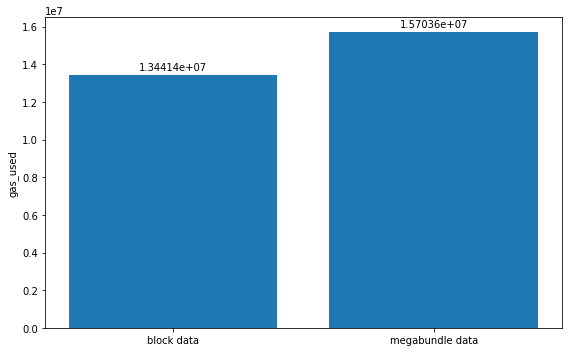

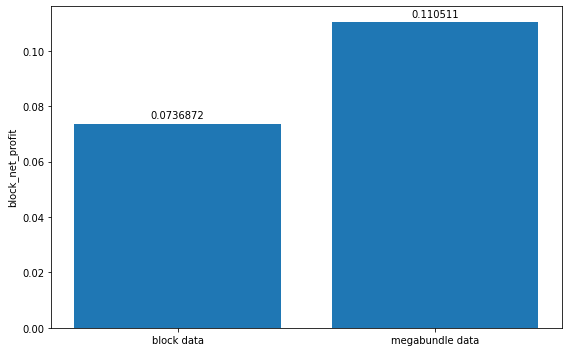

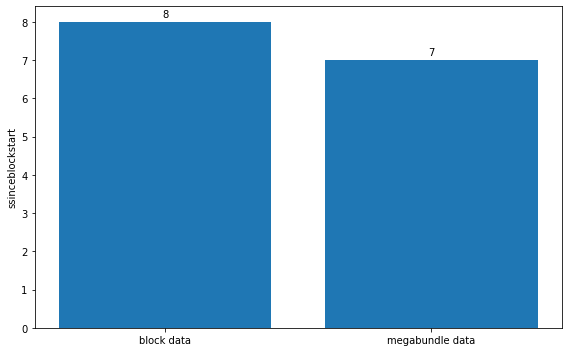

In [323]:
## Compare average feature values
bar_plot(block_data, mega_data, groupby1="isonchain_lr", groupby2="isonchain_lr_mega",var1='gas_used', var2='gasused', label1="block data", label2="megabundle data", method='mean')
bar_plot(block_data, mega_data, groupby1="isonchain_lr", groupby2="isonchain_lr_mega",var1='block_net_profit', var2='profiteth', label1="block data", label2="megabundle data", method='median')
bar_plot(block_data, mega_data, groupby1="isonchain_lr", groupby2="isonchain_lr_mega",var1='ssinceblockstart', var2='ssinceblockstart', label1="block data", label2="megabundle data", method='median')


When looking at the list of blocks that are predicted to have megabundles from the logistic regression, 68% of the total blocks will have a megabundle land on them, 11% have seen a megabundle but will fail to include it on-chain. The remaining 21% of the blocks do not have a corresponding simulated megabundle from the mev-geth logger, so the data is not available to tell.

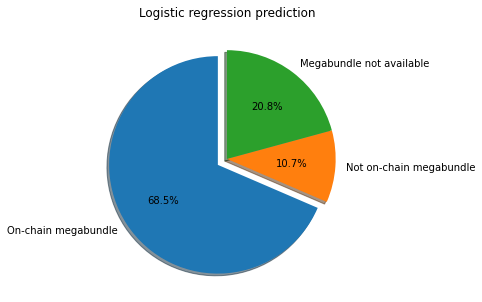

In [324]:
## List of blocks with megabundles predicted to land on-chain
block_mega_lr = block_data.merge(mega_data[['blocknumber','isonchain_lr_mega','ssinceblockstart','profiteth']], left_on='block_number', right_on='blocknumber', how='left')
block_mega_lr = block_mega_lr.rename(columns={"ssinceblockstart_x":"ssinceblockstart", "ssinceblockstart_y":"ssinceblockstart_mega"})

lr_notonchain = block_mega_lr[block_mega_lr.isonchain_lr_mega == 0].shape[0]
lr_onchain = block_mega_lr[block_mega_lr.isonchain_lr_mega == 1].shape[0]
lr_na = block_mega_lr[pd.isna(block_mega_lr.isonchain_lr_mega)].shape[0]

## Percentage of blocks with megabundle land on-chain
lr_labels = 'On-chain megabundle', 'Not on-chain megabundle', 'Megabundle not available'
lr_sizes = [lr_onchain, lr_notonchain, lr_na]
lr_explode = (0.1, 0, 0)
fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(lr_sizes, explode=lr_explode, labels=lr_labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title("Logistic regression prediction")
plt.show()

Using the same definitions in **Section 3.2.1** to calculate the three types of potential profit lost, the following can found:

In [325]:
## Total profit lost (in eth)
block_mega_lr['profit_lost'] = block_mega_lr['profiteth'] - block_mega_lr['block_net_profit']
lr_total_lost = (block_mega_lr[(block_mega_lr['isonchain_lr_mega']==1)&(block_mega_lr['profit_lost']>0)]['profit_lost']).sum()
print('The total profit lost from', total_n_blocks, 'blocks is: ', np.round(lr_total_lost, 0), "ETH")
print('The average profit lost per block is: ', np.round(lr_total_lost/total_n_blocks, 4), "ETH")

## Profit lost due to latency (in eth)
lr_mega_latency_lost = (block_mega_lr[(block_mega_lr['isonchain_lr_mega']==1)&(block_mega_lr['profit_lost']>0)&(block_mega_lr['ssinceblockstart_mega']>block_mega_lr['ssinceblockstart'])]['profit_lost']).sum()
lr_block_latency_lost = (block_mega_lr[(block_mega_lr['isonchain_lr_mega']==1)&(block_mega_lr['profit_lost']>0)&(block_mega_lr['ssinceblockstart_mega']<block_mega_lr['ssinceblockstart'])]['profit_lost']).sum()

print('The profit lost due to block latency is: ', np.round(lr_block_latency_lost, 0), "ETH")
print('The average profit lost per block due to block latency is: ', np.round(lr_block_latency_lost/total_n_blocks, 4), "ETH")

print('The profit that could have been lost due to megabundle latency is: ', np.round(lr_mega_latency_lost, 0), "ETH")
print('The average profit lost per block due to megabundle latency is: ', np.round(lr_mega_latency_lost/total_n_blocks, 4), "ETH")



The total profit lost from 132593 blocks is:  7069.0 ETH
The average profit lost per block is:  0.0533 ETH
The profit lost due to block latency is:  5038.0 ETH
The average profit lost per block due to block latency is:  0.038 ETH
The profit that could have been lost due to megabundle latency is:  550.0 ETH
The average profit lost per block due to megabundle latency is:  0.0041 ETH


**Model performance**

The logistic regression's model performance is assessed using the following evaluation metrics:
- [Balanced Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [F-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix)

Higher values of these metrics indicate better model performance, except for log loss where lower values indicate better performance.

Comparing the evaluation metrics between the training set and the testing set, all of them have very similar values. This shows the model performs identically well for both datasets and there is no evidence of overfitting the training set. 

The confusion matrix from both datasets also show a very low percentage of mis-classifications, only around 5% of false negatives ie. not on-chain predicted as on-chain.


Balanced Accuracy Score:  0.97
Log Loss:  1.58
Precision:  0.97
Recall:  0.95
F-score:  0.96
None
Balanced Accuracy Score:  0.97
Log Loss:  1.59
Precision:  0.97
Recall:  0.95
F-score:  0.96
None


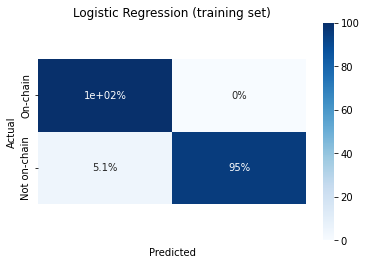

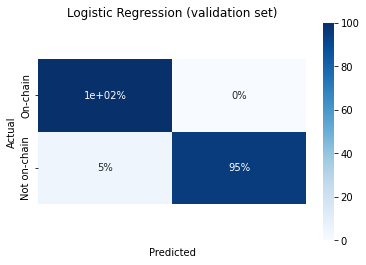

In [330]:
## Performance
## Training set (block data)
lr_train_eval = model_performance(y_train, block_data['isonchain_lr'])  
print(lr_train_eval)
plot_confusion_matrix(y_train, block_data['isonchain_lr'], class_name=['On-chain','Not on-chain'],
                      title = 'Logistic Regression (training set)'
)

## Testing set (megabundle)
lr_test_eval = model_performance(y_test, mega_data['isonchain_lr_mega'])   
print(lr_test_eval)
plot_confusion_matrix(y_test, mega_data['isonchain_lr_mega'], class_name=['On-chain','Not on-chain'],
                      title = 'Logistic Regression (validation set)'
)


**Logistic regression with cross-validation**

To further check if there is any overfitting (or underfitting) in the logistic regression, the following code runs the same model with the same four independent variables but with a 5-fold cross validation.

The model performance from the Logistic regression with 5-fold cross validation shows similar results to the Logistic regression without it. So the predictions from the previous section is valid.

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Balanced Accuracy Score:  0.95
Log Loss:  1.49
Precision:  0.97
Recall:  0.96
F-score:  0.96
None
Balanced Accuracy Score:  0.97
Log Loss:  1.5
Precision:  0.97
Recall:  0.96
F-score:  0.96
None


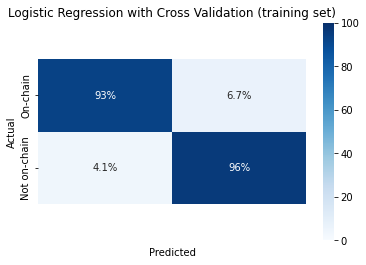

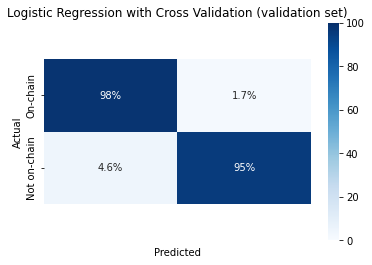

In [327]:
##############################
## 3.2.2.2 Logistic with CV ##
##############################
## Define the split into 5 folds 
kf = KFold(n_splits=5, random_state=123, shuffle=True)
logreg_cv = LogisticRegressionCV(solver="lbfgs", random_state=123, cv = kf.split(x_train)).fit(x_train, y_train)

## Training set (block data) prediction
y_pred = pd.DataFrame(logreg_cv.predict(x_train))

## Testing set (megabundle) prediction
y_test_pred = pd.DataFrame(logreg_cv.predict(x_test))

## Performance
## Training set (block data)
lrcv_train_eval = model_performance(y_train, y_pred)  
print(lrcv_train_eval)

plot_confusion_matrix(y_train, y_pred, class_name=['On-chain','Not on-chain'],
                      title = 'Logistic Regression with Cross Validation (training set)'
)


## Testing set (megabundle)
lrcv_test_eval = model_performance(y_test, y_test_pred)   
print(lrcv_test_eval)
plot_confusion_matrix(y_test, y_test_pred, class_name=['On-chain','Not on-chain'],
                      title = 'Logistic Regression with Cross Validation (validation set)'
)


## 4. Conclusion

Three models have been built in the attempt to answer the questions of whether a megabundle is expected to land on-chain; and the percentage of blocks that will have a megabundle land on them. Using the K Means model to find the relevant features, and the Gamma distribution and the Logistic regression to predict the binary event of megabundle landing on-chain or not, the following results are obtained.

- Gamma distribution predicts with a 90% confidence level that 72% of the blocks is expected to have a megabundle land on-chain. The additional profits that could have been made if these megabundles were included on-chain are 7,751 ETH. The same additional profit that could have been made due to the latency of the block is 5,517 ETH.

- Logistic regression predicts with a 90% confidence level that 68% of the blocks is expected to have a megabundle land on-chain. The additional profits that could have been made if these megabundles were included on-chain are 7,069 ETH. The same additional profit that could have been made due to the latency of the block is 5,037 ETH.


In [328]:
output = pd.DataFrame({'Model':['Gamma Distribution','Logistic Regression'], 
                       '% of Blocks with Megabundle':[str(np.round(n_onchain/len(block_mega_profit)*100,2)) + '%', str(np.round(lr_onchain/len(block_mega_lr)*100,2)) + '%'],
                      'Total Profit Lost':[np.round(total_lost,2), np.round(lr_total_lost,2)],
                      'Profit Lost from Block Latency': [np.round(block_latency_lost,2),np.round(lr_block_latency_lost,2)],
                      'Profit Lost from Megabundle Latency': [np.round(mega_latency_lost,2),np.round(lr_mega_latency_lost,2)]})
output

,Model,% of Blocks with Megabundle,Total Profit Lost,Profit Lost from Block Latency,Profit Lost from Megabundle Latency
0,Gamma Distribution,72.17%,7751.82,5517.37,626.79
1,Logistic Regression,68.53%,7069.46,5037.73,549.54


## 5. Assumptions, Limitations & Future Improvements

The models developed for the purpose of megabundle on-chain predictions are based on these key assumptions:
- The shorter the seconds since block start ('ssinceblockstart'), the more likely a megabunle will land on-chian.
- The actual 'ssinceblockstart' data points follow a Gamma distribution.
- The megabundle 'ssinceblockstart' also follows the same distribution as the block data -  a Gamma distribution.
- The threshold of 30 seconds based on the 90 percentile point of the 'ssinceblockstart' distribution is a reasonable cutoff point to distinguish high probability and low probability event of landing on-chain. The high probability approximates the land on-chain event 1 while the low probability approximates the fail to land on-chian event 0.
- Only one megabundle lands on each block.

Due to the lack of data for the 0 event (fail to land on-chain) and the limited common features available for block data and megabundle data, the following limitations and possible future improvements should be noted:
- There is no data for bundles that actually fail to land on chain. So a threshold approximating this event needs to be assumed. The model can be significantly more accurate if the actual fail to land on-chain data is available.
- The block data's time is only available to seconds whereas the megabundle simulated data has time intervals up to millieseconds. 'ssinceblockstart' with 0 value in the block data need to be replaced with a very small value close to 0 to avoid infinity (or extremely large values) in the distribution. If milliseconds are available, the 0 points could be filled with these values and a more accurate fit on the left-hand-side of the distribution can be obtained.
- There are only 4 common features between the block data and the megabundle data for the variable selection. If more features are available, the model fit could be improved.

- The model results are heavily dependent on the threshold chosen. If a different threshold i.e. 99 percentile is chosen, the percentage of blocks having megabundles will also change. The code has the flexibility to allow inputs of different thresholds for testing and comparing different outcomes.
